In [4]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_ibm_provider import IBMProvider, least_busy
from qiskit.circuit.library.standard_gates import XGate
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime import QiskitRuntimeService, Options, Sampler, Session

In [5]:
import warnings
import contextlib

import requests
from urllib3.exceptions import InsecureRequestWarning

old_merge_environment_settings = requests.Session.merge_environment_settings

@contextlib.contextmanager
def no_ssl_verification():
    opened_adapters = set()

    def merge_environment_settings(self, url, proxies, stream, verify, cert):
        # Verification happens only once per connection so we need to close
        # all the opened adapters once we're done. Otherwise, the effects of
        # verify=False persist beyond the end of this context manager.
        opened_adapters.add(self.get_adapter(url))

        settings = old_merge_environment_settings(self, url, proxies, stream, verify, cert)
        settings['verify'] = False

        return settings

    requests.Session.merge_environment_settings = merge_environment_settings

    try:
        with warnings.catch_warnings():
            warnings.simplefilter('ignore', InsecureRequestWarning)
            yield
    finally:
        requests.Session.merge_environment_settings = old_merge_environment_settings

        for adapter in opened_adapters:
            try:
                adapter.close()
            except:
                pass

In [6]:
# This notebook uses the IBM Cloud Account for running Qiskit Runtime: https://cloud.ibm.com/ 
# Note that in order to use the cloud channel you'll have to create an IBM cloud account first.
# Using the Cloud Channel is free for using simulators
# Probably we should create one set of API keys and Clour CRNs for the entire team.

In [14]:
# Your can find your API keys here: https://cloud.ibm.com/iam/apikeys
MY_IBM_CLOUD_API_KEY = "?"
# You can find your Cloud Resource Name instances here: https://cloud.ibm.com/quantum/instances
MY_IBM_CLOUD_CRN = "?"

In [8]:
# Save cloud channel credentials locally in $HOME/.qiskit/qiskit-ibm.json (you'll need to run this only once!). 
# QiskitRuntimeService.save_account(channel="ibm_cloud", token=MY_IBM_CLOUD_API_KEY, instance=MY_IBM_CLOUD_CRN, overwrite=True)

In [9]:
# Load a previously saved account and optionally select a 
# different hub/group/project in case you have access
with no_ssl_verification():
    provider = IBMProvider(instance="ibm-q/open/main")

In [10]:
# Creat a quantum circuit
cr = ClassicalRegister(5)
qr = QuantumRegister(5)
qc = QuantumCircuit(qr, cr)

qc.h(qr[0])
qc.id(qr[1])
qc.h(qr[2])
qc.id(qr[3])
qc.t(qr[4])

qc.append(XGate().control(num_ctrl_qubits=1, ctrl_state='1'), [qr[0], qr[1]])
qc.append(XGate().control(num_ctrl_qubits=1, ctrl_state='1'), [qr[2], qr[3]])

# Circuit optimizations, if any, are 
# not applied beyond the barrier
qc.barrier()

qc.measure(0, 0)
qc.measure(1, 1)
qc.measure(2, 2)
qc.measure(3, 3)
qc.measure(4, 4)

# Visualize the quantum circuit
qc.draw()

┌───┐      ░ ┌─┐            
q0_0: ┤ H ├──■───░─┤M├────────────
      ├───┤┌─┴─┐ ░ └╥┘┌─┐         
q0_1: ┤ I ├┤ X ├─░──╫─┤M├─────────
      ├───┤└───┘ ░  ║ └╥┘┌─┐      
q0_2: ┤ H ├──■───░──╫──╫─┤M├──────
      ├───┤┌─┴─┐ ░  ║  ║ └╥┘┌─┐   
q0_3: ┤ I ├┤ X ├─░──╫──╫──╫─┤M├───
      ├───┤└───┘ ░  ║  ║  ║ └╥┘┌─┐
q0_4: ┤ T ├──────░──╫──╫──╫──╫─┤M├
      └───┘      ░  ║  ║  ║  ║ └╥┘
c0: 5/══════════════╩══╩══╩══╩══╩═
                    0  1  2  3  4

In [11]:
# Select quantum device to run on. Select simulator -> True if you want to run on a simulator which is faster
# INSPECT DEVICES YOU HAVE ACCESS TO HERE: https://quantum-computing.ibm.com/services/resources?tab=yours
with no_ssl_verification():
    backends = provider.backends(filters=lambda x: x.configuration().n_qubits >= (len(qc.qubits)) \
        and (x.configuration().simulator == True) and (x.status().operational))
    backend = least_busy(backends)
    print("Selected the least busy backend: ", backend.name)

Selected the least busy backend:  ibmq_qasm_simulator


In [12]:
# If using a simulator it is recommended to use ibmq_qasm_simulator 
# since it works like a real quantum device, other simulators are different
with no_ssl_verification():
    backend = provider.get_backend("ibmq_qasm_simulator")

In [15]:
# Qiskit Runtime: is a programming model and containerized environment for deploying quantum programs, designed to reduce the 
# computational cycle time between quantum and classical computers. For details please checkout following resources
# https://medium.com/qiskit/so-what-is-qiskit-runtime-anyway-c78aecf3742
# https://qiskit.org/ecosystem/ibm-runtime/
with no_ssl_verification():
    service = QiskitRuntimeService(channel="ibm_cloud", instance=MY_IBM_CLOUD_CRN) # ADD YOUR CRN HERE !!!
    backend = service.backend(backend.name)

### You need to pay only if use real quantum devices accesed via the the IBM Cloud Channel. Using simulators is free.

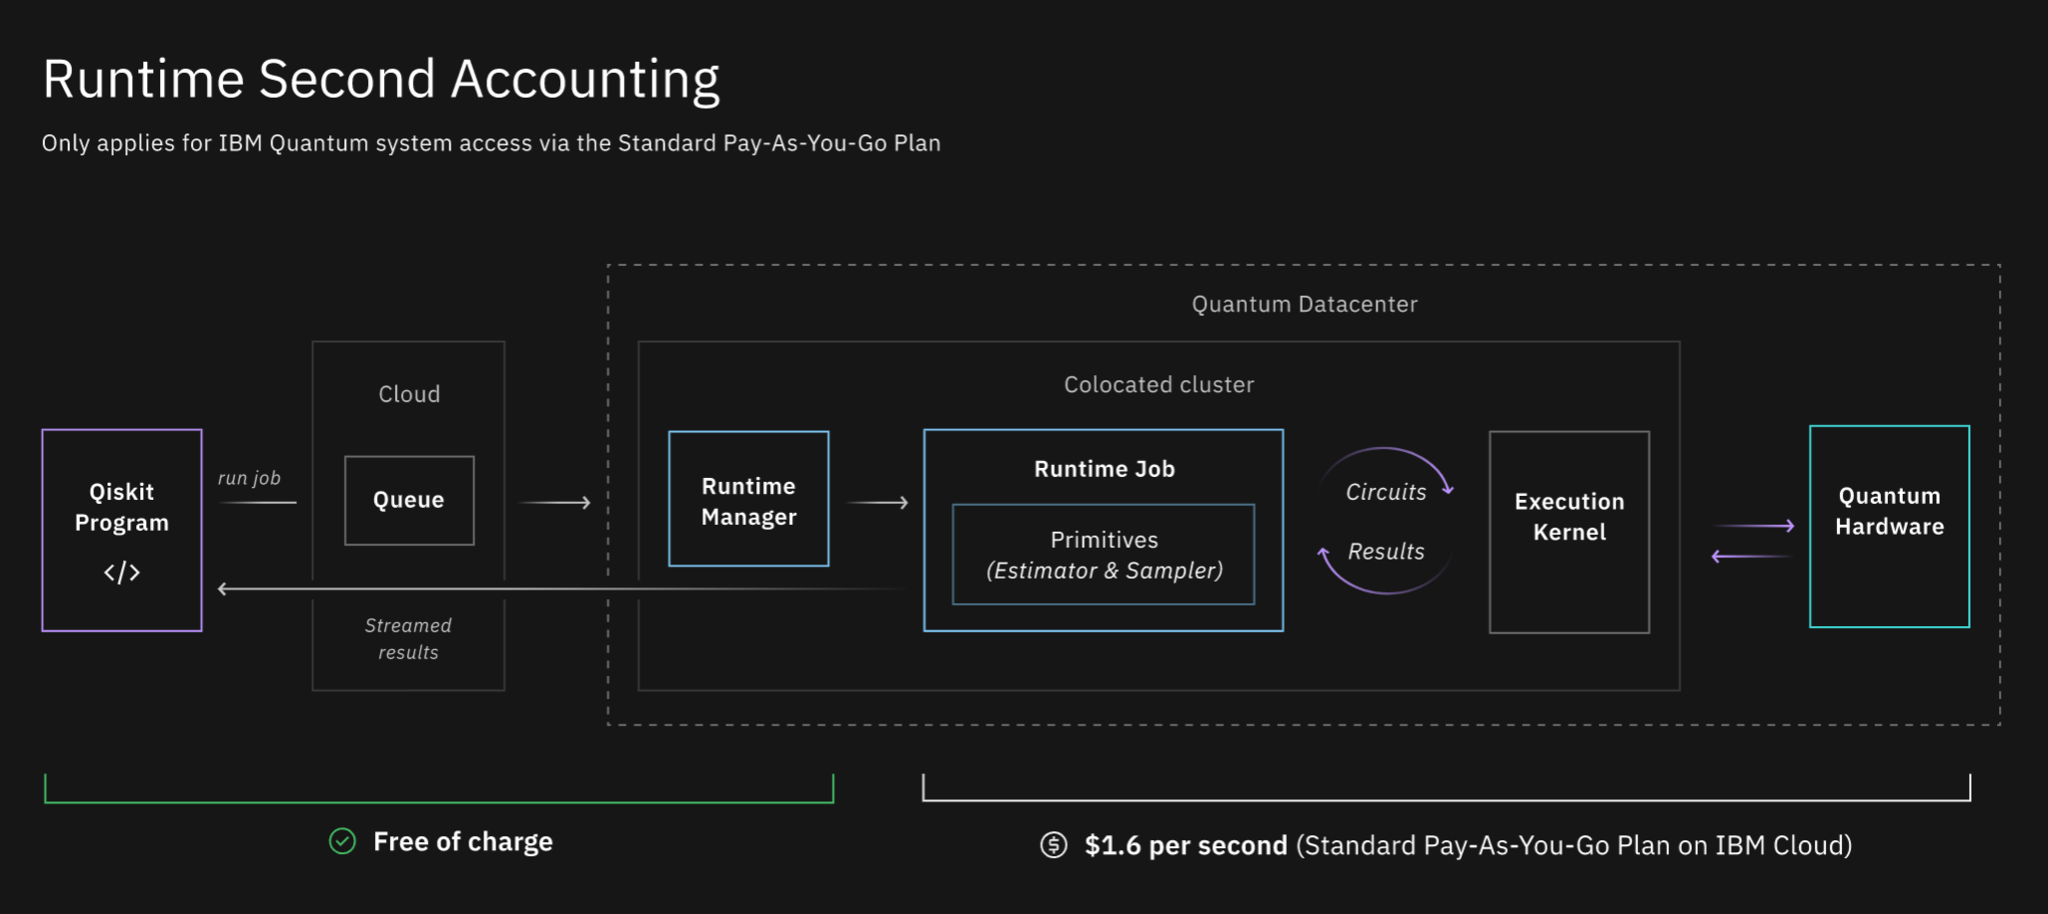

In [16]:
# initializing an instance of qiskit_ibm_runtime.Sampler rather than 
# qiskit.primitives.Sampler to use Qiskit Runtime’s implementation of the Sampler
options = Options(environment={"log_level": "INFO"})
# optimization_level=3 adds dynamical decoupling
options.optimization_level=3
# resilience_level=1 adds readout error mitigation
options.resilience_level=1
options.execution.shots = 100

In [17]:
with no_ssl_verification():
    with Session(backend=backend, max_time="1h"):
        sampler = Sampler(options=options)
        try:
            job = sampler.run(qc)
        except Exception as ex:
            print(ex.message)

In [19]:
# Verify job status
with no_ssl_verification():
    print(job.status())

JobStatus.DONE


In [56]:
# INSPECT YOUR JOBS HERE: https://quantum-computing.ibm.com/jobs

In [20]:
with no_ssl_verification():
    result = job.result()
    print(f">>> {result}")
    print(f"  > Quasi-probability distribution: {result.quasi_dists[0]}")
    print(f"  > Metadata: {result.metadata[0]}")

>>> SamplerResult(quasi_dists=[{0: 0.21, 3: 0.27, 12: 0.25, 15: 0.27}], metadata=[{'shots': 100, 'readout_mitigation_overhead': 1.0, 'readout_mitigation_time': 0.00839529896620661, 'circuit_metadata': {}}])
  > Quasi-probability distribution: {0: 0.21, 3: 0.27, 12: 0.25, 15: 0.27}
  > Metadata: {'shots': 100, 'readout_mitigation_overhead': 1.0, 'readout_mitigation_time': 0.00839529896620661, 'circuit_metadata': {}}


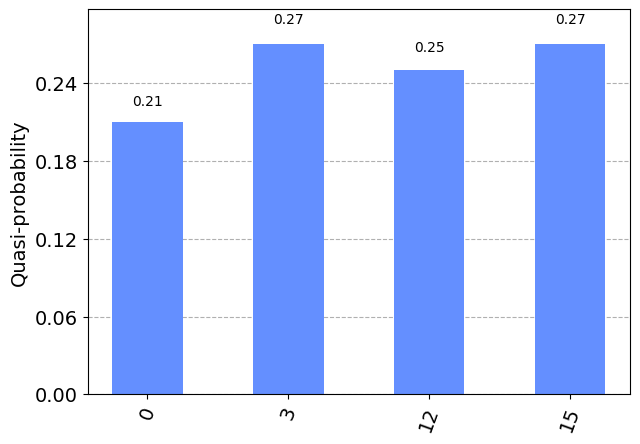

In [21]:
plot_histogram(result.quasi_dists)

In [59]:
from qiskit.tools.jupyter import *

%qiskit_version_table